# Get graph embeddings from GraphSage output

In [1]:
%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient, GEOSPHERE
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
import collections
from os import path

In [2]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [3]:
top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

dir_format = '/yagami/lyl/project/GraphSAGE/unsup-GraphSAGE_input/{}_graphsage_mean_small_0.000010'

## Get Graph Embeddings for each cascade graph

In [4]:
business_ids = list(db.city_business.find(
        {},
        {
            '_id': 0,
            'business_id': 1
        }
    ))

In [5]:
embedding_graph = {}

for i, business in enumerate(business_ids):
    business_id = business['business_id']
    dir_name = dir_format.format(business_id)
    val_npy_loc = path.join(dir_name, 'val.npy')
    if not path.exists(val_npy_loc):
        continue
    embedding_mat = np.load(val_npy_loc)
    
    embedding_avg = np.average(embedding_mat, axis=0)
    embedding_sum = np.sum(embedding_mat, axis=0)
    embedding = np.concatenate((embedding_avg, embedding_sum)) 
    embedding_graph[business_id] = embedding

In [6]:
len(embedding_graph)

10377

## Get business popularity score from database

In [7]:
import json 

def business_id_list(path):
    id_list = []
    i = 0
    with open(path, 'r') as f:
        for line in f:
            i += 1
            id_list.append(line[:-1])
            # if i > 8000:
            #     break
    return id_list

business_ids = business_id_list('GraphSAGE_input/bid.txt')
business_ranking = json.load(open('business-ranking.json'))

In [8]:
def popularity_score(rank, neighbors):
    return np.power(float(rank) / neighbors, 1)

In [9]:
# create a n x m dimensional matrix of embedding & value

x = []
y = []
for i, business in enumerate(business_ids):
    business_id = business
    if business_id in embedding_graph and business_id in business_ranking:
        rank, neighbors = business_ranking[business_id]['rank'], business_ranking[business_id]['neighbors']
        x.append(embedding_graph[business_id])
        y.append(popularity_score(rank, neighbors))
x, y = np.array(x), np.array(y)

In [10]:
x.shape

(10377, 40)

In [11]:
n, m = x.shape  # n = number of test data, m = dimension

In [12]:
indices = np.random.permutation(n)
offset_train, offset_dev, offset_test = 0, int(n * 0.6), int(n * 0.8)
train, dev, test = indices[offset_train : offset_dev], indices[offset_dev : offset_test], indices[offset_test :]

x_train, x_dev, x_test = x[train, :], x[dev, :], x[test, :]
y_train, y_dev, y_test = y[train], y[dev], y[test]

In [13]:
y_test

array([0.67762128, 0.49622926, 0.25864662, ..., 0.22811671, 0.25380711,
       0.33333333])

## Regression

In [14]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [38]:
for count, degree in enumerate([2, 3, 4]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(solver='svd'))
    model.fit(x_train, y_train)
    y_test_output = model.predict(x_test)
    accuracy = np.sum(y_test == y_test_output)
    print y_dev.shape, accuracy

(1119,) 0


KeyboardInterrupt: 

In [ ]:
np.sum((y_test < 0.1) == (y_test_output < 0.1))

In [ ]:
np.sum((y_test < 0.1))

In [ ]:
np.sum(np.logical_and((y_test_output < 0.1), (y_test < 0.1)))

In [ ]:
np.sum(y_test_output < 0.1)

In [21]:
best_r2, best_model = r2_score_result(y_test, y_test_output), model

r2 score is 0.441720


In [ ]:
for i in range(20):
    mlp = MLPRegressor(hidden_layer_sizes=(200, 300, 200, 50), activation='relu', solver='adam', alpha=0.0001, verbose=False)
    mlp.out_activation_ = 'sigmoid'
    model = make_pipeline(mlp)
    model.fit(x_train, y_train)
    y_test_output = model.predict(x_test)
    r2 = r2_score_result(y_test, y_test_output)
    print r2
    if r2 > best_r2:
        best_r2, best_model = r2, model

<IPython.core.display.Javascript object>


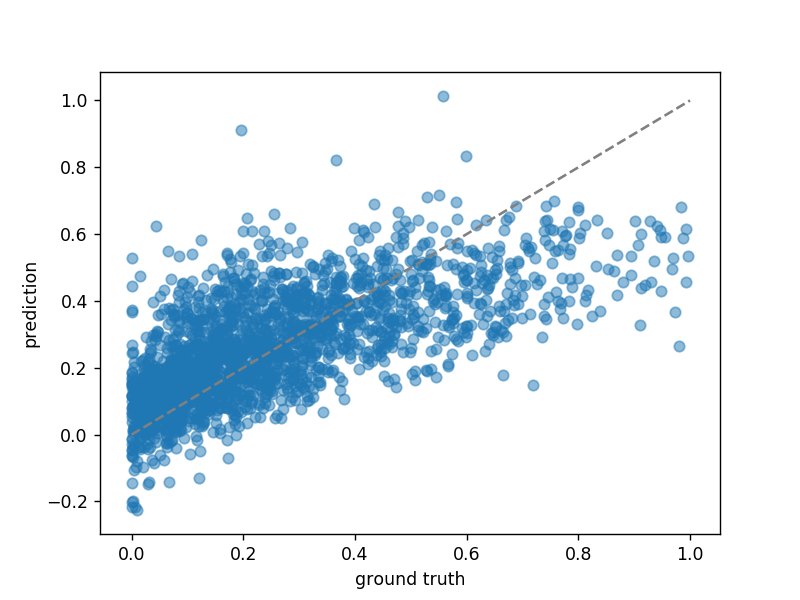

In [17]:
def plot_regress_viz(ground_truth, prediction):
    plt.figure()
    plt.scatter(ground_truth, prediction, alpha=0.5)
    reference_line = np.array([0, 0.5, 1])
    plt.plot(reference_line, reference_line, '--', color='grey')
    plt.xlabel('ground truth')
    plt.ylabel('prediction')
    plt.show()

def r2_score_result(ground_truth, prediction):
    s = r2_score(ground_truth, prediction)
    print 'r2 score is %f' % s
    return s
plot_regress_viz(y_test, y_test_output)

In [18]:
print r2_score_result(y_test, y_test_output)

r2 score is 0.441720
0.4417197774752517
